# NYC TLC data project


## Description
Author: Shuheng Mo       
Contact: shuheng_mo@outlook.com, shuheng_mo_mail@163.com      
Notifications: Running data processing sections might be time-consuming, for readers who focus on results and and conclusions please load processed(cleaned) data from folder `clean_data/` and start from section `Exploratory Data Analysis`.

## Business Understanding
In Newyork City, all taxi vehicles are managed by TLC (Taxi and Limousine Commission), here is a brief description about TLC:
```
The New York City Taxi and Limousine Commission (TLC), created in 1971, is the agency 
responsible for licensing and regulating New York City's Medallion (Yellow) taxi cabs, for-hire 
vehicles (community-based liveries, black cars and luxury limousines), commuter vans, and 
paratransit vehicles. The Commission's Board consists of nine members, eight of whom are 
unsalaried Commissioners. The salaried Chair/ Commissioner presides over regularly 
scheduled public commission meetings and is the head of the agency, which maintains a 
staff of approximately 600 TLC employees.
Over 200,000 TLC licensees complete approximately 1,000,000 trips each day. To operate for 
hire, drivers must first undergo a background check, have a safe driving record, and 
complete 24 hours of driver training. TLC-licensed vehicles are inspected for safety and 
emissions at TLC's Woodside Inspection Facility.
```
Now NYC TLC has released its Trip Record data to public for research and study purposes. There are three main taxi types in NYC:
* Yellow taxis are traditionally hailed by signaling to a driver who is on duty and seeking a 
passenger (street hail), but now they may also be hailed using an e-hail app like Curb or Arro. 
Yellow taxis are the only vehicles permitted to respond to a street hail from a passenger in all 
five boroughs.
* Green taxis, also known as boro taxis and street-hail liveries, were introduced in August of 
2013 to improve taxi service and availability in the boroughs. Green taxis may respond to 
street hails, but only in the areas indicated in green on the map (i.e. above W 110 St/E 96th St 
in Manhattan and in the boroughs).
* FHV data includes trip data from high-volume for-hire vehicle bases (bases for companies 
dispatching 10,000+ trip per day, meaning Uber, Lyft, Via, and Juno), community livery bases, 
luxury limousine bases, and black car bases.              

Uber as one of the biggest ride-hailing services providers, its trip records are collected in `High Volume For-Hire Vehicle Trip 
Records` as well. In this project, there are three business goals we want to achieve to improve Uber's ride-hailing service:
1. Exploratory data analysis, research data `fhvhv_tripdata_2021-01` and figure out underlying trip patterns in Jan,2021.
2. Based on `fhvhv_tripdata_2021-01` and weather data, build predict model to predict the peak footfall. 
3. Try explore Uber's user portrait and study the user's wishes when the price was increased.

## Data requirements
Because of the privacy policy, some user data has been encrypted or masked.

## Data collection

TLC provided the data and downloaded as `NYC TLC.zip`, the file structure of decompressed folder `NYC TLC`:
```
.
├── data_dictionary_trip_records_hvfhs.pdf
├── fhvhv_tripdata_2021-01.parquet
├── fhvhv_tripdata_2021-02.parquet
├── fhvhv_tripdata_2021-03.parquet
├── fhvhv_tripdata_2021-04.parquet
├── fhvhv_tripdata_2021-05.parquet
├── fhvhv_tripdata_2021-06.parquet
├── fhvhv_tripdata_2021-07.parquet
├── fhvhv_tripdata_2021-08.parquet
├── fhvhv_tripdata_2021-09.parquet
├── fhvhv_tripdata_2021-10.parquet
├── fhvhv_tripdata_2021-11.parquet
├── fhvhv_tripdata_2021-12.parquet
├── nyc 2021-01-01 to 2021-12-31.csv
├── taxi+_zone_lookup.csv
├── taxi_zones
│   ├── taxi_zones.dbf
│   ├── taxi_zones.prj
│   ├── taxi_zones.sbn
│   ├── taxi_zones.sbx
│   ├── taxi_zones.shp
│   ├── taxi_zones.shp.xml
│   └── taxi_zones.shx
├── taxi_zones.zip
└── working_parquet_format.pdf
```
which `nyc 2021-01-01 to 2021-12-31.csv` record the weather data of year 2021,`taxi+_zone_lookup.csv` stored the zone information of all taxi, data file end with `.parquet` will be processed with pyarrow.

## Data understanding
The data dictionary of Trip Record data please refer to official site https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page.         
or just read the summary in `data_dictionary_trip_records_hvfhs.pdf`. Datasets that will be used are explained:

Dataset 1: fhvhv_tripdata_2021-01.parquet, 11908468 rows, 24 columns
- Features: (see 'data_dictionary_trip_records_hvfhs.pdf')     
Multiple dataset end with `.parquet` could be used according to requirements.

Dataset 2: nyc 2021-01-01 to 2021-12-31.csv, 365 rows, 21 columns
- Features:
    - 'name':
    - 'address':
    - 'resolvedAddress':
    - 'datetime':
    - 'temp':
    - 'feelslike':
    - 'dew':
    - 'humidity':
    - 'precip':
    - 'precipprob':
    - 'preciptype':
    - 'snow':
    - 'snowdepth':
    - 'windgust':
    - 'windspeed':
    - 'winddir':
    - 'sealevelpressure':
    - 'cloudcover':
    - 'visibility':
    - 'uvindex':
    - 'severerisk':

Dataset 3: taxi+_zone_lookup.csv, 265 rows, 4 columns
- Features:
    - LocationID:
    - Borough:
    - Zone:
    - service_zone:

## Pre-requisites & Auxiliary Functions

In [1]:
# ! pip install -r requirements.txt
## imports
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import folium
import xgboost as xgb
import plotly.express as px
from datetime import time
from PIL import Image
from time import perf_counter
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression,Lasso,LassoCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from folium.plugins import HeatMap, HeatMapWithTime

## migic functions
%matplotlib inline

# auxiliary functions
## data processing methods
def check_missing_val(data):
    print("Checking attributes that have missing values...")
    for col in data.columns:
        if data[col].isnull().sum() !=0:
            print("{} : {}".format(col,data[col].isnull().sum()))

def check_uniqueness(data):
    print("Checking uniqueness of each attributes ...")
    for col in data.columns:
        print("{} : {} -> {}".format(col,data[col].is_unique,len(data[col].unique())))
        
def get_quantile(data,col_name,q_val,inter):
    return np.percentile(data[col_name],q_val,method=inter)

def iqr_test(data,col_name,inter):
    qu = get_quantile(data,'quantity',75,inter)
    ql = get_quantile(data,'quantity',25,inter)
    diff = qu - ql
    U = qu + 1.5 * diff
    L = ql - 1.5 * diff
    return U,L

def remove_outliers(data,col_name,inter):
    """filter the outliers of the numerical data

    Args:
        data (_type_): _description_
        col_name (_type_): _description_
        inter (_type_): _description_

    Returns:
        _type_: _description_
    """
    U,L = iqr_test(data,col_name,inter)
    return data[data[col_name]>= L | data[col_name]<=U]
    
        
def get_kmeans_categories(centroid,centers):
    """Returns the correct class when centroid is given

    Args:
        centroid (float): centroid assigned to given order
        centers (float): all centroids given by KNN

    Returns:
        str: specified distance range
    """
    if centroid == centers[0]:
        return 'short_range'
    elif centroid == centers[1]:
        return 'mid_range'
    else:
        return 'long_range'
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix. 
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Data Wrangling

### Data Loading and pre-processing

In [103]:
fhvhv_tripdata_2021_01 = pq.read_table('NYC TLC/fhvhv_tripdata_2021-01.parquet')
fhvhv_tripdata_2021_01 = fhvhv_tripdata_2021_01.to_pandas()

In [104]:
fhvhv_tripdata_2021_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11908468 entries, 0 to 11908467
Data columns (total 24 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   dispatching_base_num  object        
 2   originating_base_num  object        
 3   request_datetime      datetime64[ns]
 4   on_scene_datetime     datetime64[ns]
 5   pickup_datetime       datetime64[ns]
 6   dropoff_datetime      datetime64[ns]
 7   PULocationID          int64         
 8   DOLocationID          int64         
 9   trip_miles            float64       
 10  trip_time             int64         
 11  base_passenger_fare   float64       
 12  tolls                 float64       
 13  bcf                   float64       
 14  sales_tax             float64       
 15  congestion_surcharge  float64       
 16  airport_fee           float64       
 17  tips                  float64       
 18  driver_pay            float64       
 19

In [105]:
# we see those flags are boolean values, can be represented as 0 and 1
fhvhv_tripdata_2021_01['shared_request_flag'] = fhvhv_tripdata_2021_01['shared_request_flag'].apply(lambda x: 1 if x == 'Y' else 0)
fhvhv_tripdata_2021_01['shared_match_flag'] = fhvhv_tripdata_2021_01['shared_match_flag'].apply(lambda x: 1 if x == 'Y' else 0)
fhvhv_tripdata_2021_01['access_a_ride_flag'] = fhvhv_tripdata_2021_01['access_a_ride_flag'].apply(lambda x: 1 if x == 'Y' else 0)
fhvhv_tripdata_2021_01['wav_request_flag'] = fhvhv_tripdata_2021_01['wav_request_flag'].apply(lambda x: 1 if x == 'Y' else 0)
fhvhv_tripdata_2021_01['wav_match_flag'] = fhvhv_tripdata_2021_01['wav_match_flag'].apply(lambda x: 1 if x == 'Y' else 0)

In [106]:
nyc_weather_2021 = pd.read_csv('NYC TLC/nyc 2021-01-01 to 2021-12-31.csv')
nyc_weather_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              365 non-null    object 
 1   address           365 non-null    object 
 2   resolvedAddress   365 non-null    object 
 3   datetime          365 non-null    object 
 4   temp              365 non-null    float64
 5   feelslike         365 non-null    float64
 6   dew               365 non-null    float64
 7   humidity          365 non-null    float64
 8   precip            365 non-null    float64
 9   precipprob        365 non-null    int64  
 10  preciptype        152 non-null    object 
 11  snow              365 non-null    float64
 12  snowdepth         365 non-null    float64
 13  windgust          292 non-null    float64
 14  windspeed         365 non-null    float64
 15  winddir           365 non-null    float64
 16  sealevelpressure  365 non-null    float64
 1

In [107]:
taxi_zone_lookup = pd.read_csv('NYC TLC/taxi+_zone_lookup.csv')
taxi_zone_lookup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LocationID    265 non-null    int64 
 1   Borough       265 non-null    object
 2   Zone          264 non-null    object
 3   service_zone  263 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.4+ KB


#### Missing values

In [108]:
check_missing_val(fhvhv_tripdata_2021_01)

Checking attributes that have missing values...
originating_base_num : 3206079
request_datetime : 4
on_scene_datetime : 3200015
airport_fee : 11902548


In [109]:
check_missing_val(nyc_weather_2021)

Checking attributes that have missing values...
preciptype : 213
windgust : 73
severerisk : 365


In [110]:
check_missing_val(taxi_zone_lookup)

Checking attributes that have missing values...
Zone : 1
service_zone : 2


In [111]:
for idx in taxi_zone_lookup.Zone.value_counts().index.to_list():
    if idx.find('Airport')!=-1:
        print(idx)

Newark Airport
LaGuardia Airport
JFK Airport


In [112]:
taxi_zone_lookup[taxi_zone_lookup.Zone.isin(['Newark Airport','LaGuardia Airport','JFK Airport'])] # airport_fee has sth to do with location ID 1,132,138

LocationID Borough               Zone service_zone
0             1     EWR     Newark Airport          EWR
131         132  Queens        JFK Airport     Airports
137         138  Queens  LaGuardia Airport     Airports

In [113]:
airport_ids = [1,132,138]

In [114]:
print(len(fhvhv_tripdata_2021_01[fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & fhvhv_tripdata_2021_01.DOLocationID.isin(airport_ids)]))
print(len(fhvhv_tripdata_2021_01[fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & ~fhvhv_tripdata_2021_01.DOLocationID.isin(airport_ids)]))
print(len(fhvhv_tripdata_2021_01[~fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & fhvhv_tripdata_2021_01.DOLocationID.isin(airport_ids)]))

6852
168695
190456


In [115]:
fhvhv_tripdata_2021_01.loc[fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & fhvhv_tripdata_2021_01.DOLocationID.isin(airport_ids),'airport_fee'] = 6852*[5]
fhvhv_tripdata_2021_01.loc[fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & ~fhvhv_tripdata_2021_01.DOLocationID.isin(airport_ids),'airport_fee'] = 168695*[2.5]
fhvhv_tripdata_2021_01.loc[~fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & fhvhv_tripdata_2021_01.DOLocationID.isin(airport_ids),'airport_fee'] = 190456*[2.5]

In [116]:
fhvhv_tripdata_2021_01['airport_fee'].fillna(value=0,inplace=True)
fhvhv_tripdata_2021_01.dropna(inplace=True) # drop the other missing values

In [117]:
nyc_weather_2021['windgust'].fillna(-1,inplace=True)
windgust_data = nyc_weather_2021['windgust'].to_list()

In [118]:
# nyc_weather_2021['windgust'].fillna(method='ffill',inplace=True)
for idx,num in enumerate(windgust_data):
    if num == -1:
        if idx == 0:
            windgust_data[idx] = windgust_data[idx+1]
        elif idx == len(windgust_data) - 1:
            windgust_data[idx] = windgust_data[idx-1]
        else:
            if windgust_data[idx-1] != -1 and windgust_data[idx+1]!= -1:
                windgust_data[idx] = (windgust_data[idx-1]+windgust_data[idx+1])/2
            else:
                windgust_data[idx] = windgust_data[idx-1] if windgust_data[idx-1]!= -1 else windgust_data[idx+1]

nyc_weather_2021['windgust'] = windgust_data

In [119]:
nyc_weather_2021['preciptype'].fillna(value='rain',inplace=True) # fill with mode, which is 'rain' 

In [120]:
nyc_weather_2021.drop(columns=['severerisk'],inplace=True) # drop the useless column

In [121]:
taxi_zone_lookup[taxi_zone_lookup.Zone.isnull()]

LocationID  Borough Zone service_zone
264         265  Unknown  NaN          NaN

In [122]:
taxi_zones = gpd.read_file(r'NYC TLC/taxi_zones/taxi_zones.shp')
taxi_zones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int64   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int64   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 14.5+ KB


In [123]:
taxi_zones[taxi_zones.LocationID==265] # no data retrieved, seems we have to drop the empty data

Empty GeoDataFrame
Columns: [OBJECTID, Shape_Leng, Shape_Area, zone, LocationID, borough, geometry]
Index: []

In [124]:
taxi_zone_lookup.dropna(inplace=True)
taxi_zones.dropna(inplace=True)

##### Duplicated values

In [125]:
fhvhv_tripdata_2021_01.drop_duplicates(inplace=True)
nyc_weather_2021.drop_duplicates(inplace=True)
taxi_zone_lookup.drop_duplicates(inplace=True)
taxi_zones.drop_duplicates(inplace=True)

#### Outliers

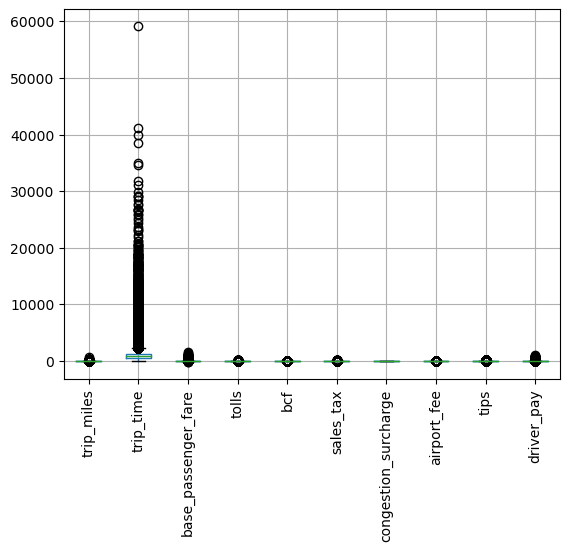

In [126]:
# do we still need to find and filter outliers for this project? suppose all the data collected well
# trip_data_outliers = fhvhv_tripdata_2021_01[['trip_miles','trip_time','base_passenger_fare','tolls','bcf',
#                        'sales_tax','congestion_surcharge','airport_fee','tips','driver_pay']].boxplot(rot=90)

# trip_data_outliers
Image.open("img/trip_data_outliers.png")

In [127]:
# trip_data_outliers.figure.savefig("img/trip_data_outliers.png",bbox_inches="tight")

No abnormal extreme values detected except for `trip_time`. However, the trip can take very long time in reality. No operation applied here.

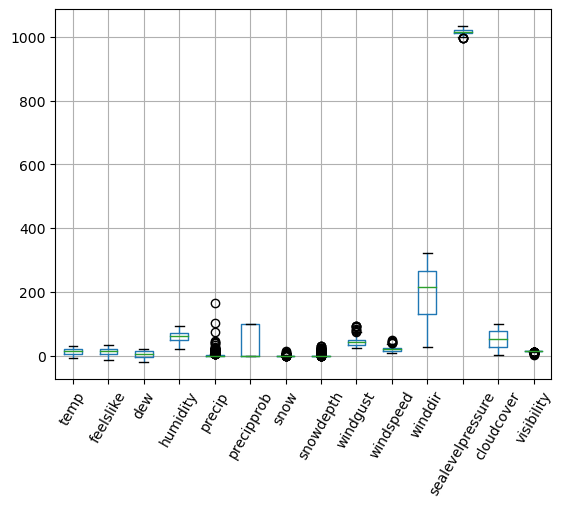

In [128]:
# weather_attrs = ['temp','feelslike','dew','humidity','precip','precipprob','snow','snowdepth','windgust','windspeed','winddir','sealevelpressure','cloudcover','visibility']
# weather_data_outliers = nyc_weather_2021[weather_attrs].boxplot(rot=60)
# weather_data_outliers
Image.open("img/weather_data_outliers.png")

In [129]:
# weather_data_outliers.figure.savefig("img/weather_data_outliers.png",bbox_inches="tight")

No abnormal extreme values detected except for `precip`. Also, we will `windgust` with our prediction and there could be further improvement.

In [130]:
# save the processed data for further purposes
fhvhv_tripdata_2021_01.to_parquet('clean_data/tripdata_2021_01.parquet',index=False)
nyc_weather_2021.to_csv('clean_data/weatherdata_2021.csv',index=False)
taxi_zones.to_file('clean_data/taxi_zones_2021.shp',index=False)
taxi_zone_lookup.to_csv('clean_data/taxi_zone_lookup_2021.csv',index=False)

## Exploratory Data Analysis (EDA)

In [131]:
# load clean data for convenience
fhvhv_tripdata_2021_01 = pq.read_table('clean_data/tripdata_2021_01.parquet').to_pandas()
nyc_weather_2021 = pd.read_csv('clean_data/weatherdata_2021.csv')
taxi_zones = gpd.read_file('clean_data/taxi_zones_2021.shp')
taxi_zone_lookup = pd.read_csv('clean_data/taxi_zone_lookup_2021.csv')

The first thing we want to investigate is, where do the most trip occured? Looking at the pickup and drop-off locations of the taxi trips, we can see that       
the distribution of those locations are quiet similar, so is there really a region where most of the trip occured in NYC? What are they? When do the customers go there?

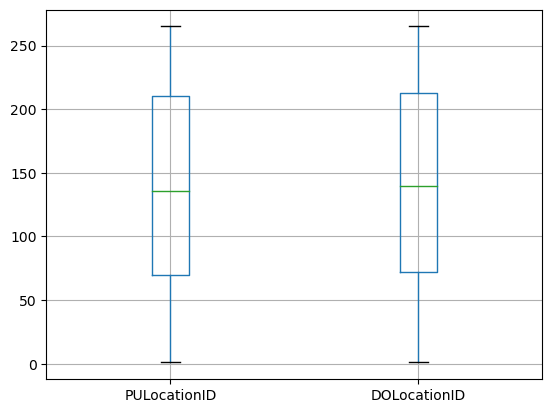

In [132]:
# trip_locations = fhvhv_tripdata_2021_01[['PULocationID','DOLocationID']].boxplot()
# trip_locations.figure.savefig("img/trip_loc_distribution.png",bbox_inches="tight")
# trip_locations
Image.open("img/trip_loc_distribution.png")

In [133]:
## warning: takes about 20 secs
# Filter the data according to our need
# All pickup (originate) locations in Jan,2021
# All drop-off (destination) locations in Jan,2021
# now seperate the data based on day (6:00-18:00) and night (18:00-6:00)
day_start = time(6,0,0)
day_end = time(18,0,0)
# locations in day time
tripdata_2021_01_src_day = fhvhv_tripdata_2021_01.loc[(fhvhv_tripdata_2021_01['pickup_datetime'].dt.time >= day_start) & (fhvhv_tripdata_2021_01['pickup_datetime'].dt.time <= day_end)]
tripdata_2021_01_dst_day = fhvhv_tripdata_2021_01.loc[(fhvhv_tripdata_2021_01['dropoff_datetime'].dt.time >= day_start) & (fhvhv_tripdata_2021_01['dropoff_datetime'].dt.time <= day_end)]
# locations in night
tripdata_2021_01_src_night = fhvhv_tripdata_2021_01.loc[(fhvhv_tripdata_2021_01['pickup_datetime'].dt.time < day_start) | (fhvhv_tripdata_2021_01['pickup_datetime'].dt.time > day_end)]
tripdata_2021_01_dst_night = fhvhv_tripdata_2021_01.loc[(fhvhv_tripdata_2021_01['dropoff_datetime'].dt.time < day_start) | (fhvhv_tripdata_2021_01['dropoff_datetime'].dt.time > day_end)]

### Geospatial Analysis

['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough', 'geometry']


<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

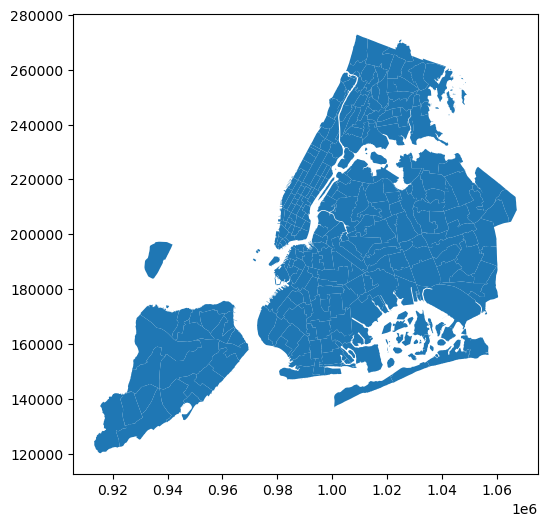

In [134]:
taxi_zones.plot(figsize=(6,6))
print(taxi_zones.columns.to_list())
taxi_zones.crs

In [135]:
taxi_zones = taxi_zones.to_crs(2263)
taxi_zones['centroid'] = taxi_zones.centroid

In [136]:
taxi_zones = taxi_zones.to_crs(epsg=4326) # project the centroids' locations to another coordinate system
taxi_zones['centroid'] = taxi_zones['centroid'].to_crs(epsg=4326)
taxi_zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  \
0            EWR  POLYGON ((-74.18445 40.69500, -74.18449 40.695...   
1         Queens  MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...   
2          Bronx  POLYGON ((-73.84793 40.87134, -73.84725 40.870...   
3      Manhattan  POLYGON ((-73.97177 40.72582, -73.97179 40.725...   
4  Staten Island  POLYGON ((-74.17422 40.56257, -74.17349 40.562...   

                     centroid  
0  POINT (-74.17400 40.69183)  
1  POINT (-73.83130 40.61675)  
2  POINT (-73.84742 40.86447)  
3  POINT (-73.97697 40.72375)  
4  POINT (-74.18849 40.55266)

In [137]:
m1 = folium.Map(location=[40.70, -73.94], zoom_start=12,tiles="Stamen Toner")

# add centroid marker to each taxi zones
latitudes = []
longitudes = []
# markers_group = folium.FeatureGroup(name='Taxi Zones Centroids')
for _, r in taxi_zones.iterrows():
    lat = r['centroid'].y
    latitudes.append(lat)
    lon = r['centroid'].x
    longitudes.append(lon)
    folium.Marker(location=[lat, lon], popup='LocationID:{}<br>Zone:{}<br>Borough:{}'.format(r['LocationID'], r['zone'], r['borough']),icon=folium.Icon(icon='info-sign')).add_to(m1)

# project geometries on the map to locate precise regions of taxi zones
for _, r in taxi_zones.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.0001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,style_function=lambda x: {'fillColor': 'green'})
    folium.Popup(r['zone']).add_to(geo_j)
    geo_j.add_to(m1)
    
# markers_group.add_to(m)
taxi_zones['c_latitude'] = latitudes
taxi_zones['c_longitude'] = longitudes
m1.save('maps/taxi_zones.html')
m1

In the following sections we will use this as an reference map.

#### Pickup locations heatmap in Jan,2021

In [138]:
pickup_loc_2021_1 = fhvhv_tripdata_2021_01[['PULocationID']].value_counts()
pickup_loc_2021_1 = pd.DataFrame(pickup_loc_2021_1)
pickup_loc_2021_1.columns = ['count']
pickup_loc_2021_1 = pickup_loc_2021_1.merge(taxi_zones,left_on='PULocationID',right_on='LocationID')[['LocationID','c_latitude','c_longitude','count']]
pickup_loc_2021_1.drop(columns=['LocationID'],inplace=True)

In [139]:
m2 = folium.Map(location=[40.70, -73.94], zoom_start=12, tiles="Stamen Toner")

pickup_loc_2021_1_group = folium.FeatureGroup(name='Jan Pickup Locations')
HeatMap(pickup_loc_2021_1,min_opacity=0.4,blur=18).add_to(pickup_loc_2021_1_group).add_to(m2)
folium.LayerControl().add_to(m2)
m2.save('maps/pickup_2021_1.html')
m2

Most of the pickup locations appears around North-East (near the coast line to Jersey city on the continent) and central part of the NYC, which are Manhattan and Brooklyn. Also we see there's a indentical pickup hotspot where located among Atlantic Avenue and Eastern Parkway with location ID 61. Take a look at this location, we found it is Brooklyn, Crown Heights North.

#### Drop-off locations heatmap in Jan,2021

In [140]:
dropoff_loc_2021_1 = fhvhv_tripdata_2021_01[['DOLocationID']].value_counts()
dropoff_loc_2021_1 = pd.DataFrame(dropoff_loc_2021_1)
dropoff_loc_2021_1.columns = ['count']
dropoff_loc_2021_1 = dropoff_loc_2021_1.merge(taxi_zones,left_on='DOLocationID',right_on='LocationID')[['LocationID','c_latitude','c_longitude','count']]
dropoff_loc_2021_1.drop(columns=['LocationID'],inplace=True)

In [141]:
m3 = folium.Map(location=[40.70, -73.94], zoom_start=12, tiles="Stamen Toner")

dropoff_loc_2021_1_group = folium.FeatureGroup(name='Jan Drop-off Locations')
HeatMap(dropoff_loc_2021_1,min_opacity=0.4,blur=18).add_to(dropoff_loc_2021_1_group).add_to(m3)
folium.LayerControl().add_to(m3)
m3.save('maps/dropoff_2021_1.html')
m3

#### Pickup locations (day&night) heatmap in Jan,2021

In [142]:
pickup_loc_2021_1_day = tripdata_2021_01_src_day[['PULocationID']].value_counts()
pickup_loc_2021_1_day = pd.DataFrame(pickup_loc_2021_1_day)
pickup_loc_2021_1_day.columns = ['count']
pickup_loc_2021_1_day = pickup_loc_2021_1_day.merge(taxi_zones,left_on='PULocationID',right_on='LocationID')[['LocationID','c_latitude','c_longitude','count']]
pickup_loc_2021_1_day.drop(columns=['LocationID'],inplace=True)

In [143]:
m4 = folium.Map(location=[40.70, -73.94], zoom_start=12, tiles="Stamen Toner")

pickup_loc_2021_1_day_group = folium.FeatureGroup(name='Jan Pickup Locations (day)')
HeatMap(pickup_loc_2021_1_day,min_opacity=0.4,blur=18).add_to(pickup_loc_2021_1_day_group).add_to(m4)
folium.LayerControl().add_to(m4)
m4.save('maps/pickup_2021_1_day.html')
m4

In [144]:
pickup_loc_2021_1_nt = tripdata_2021_01_src_night[['PULocationID']].value_counts()
pickup_loc_2021_1_nt = pd.DataFrame(pickup_loc_2021_1_nt)
pickup_loc_2021_1_nt.columns = ['count']
pickup_loc_2021_1_nt = pickup_loc_2021_1_nt.merge(taxi_zones,left_on='PULocationID',right_on='LocationID')[['LocationID','c_latitude','c_longitude','count']]
pickup_loc_2021_1_nt.drop(columns=['LocationID'],inplace=True)

In [145]:
m5 = folium.Map(location=[40.70, -73.94], zoom_start=12, tiles="Stamen Toner")

pickup_loc_2021_1_nt_group = folium.FeatureGroup(name='Jan Pickup Locations(night)')
HeatMap(pickup_loc_2021_1_nt,min_opacity=0.4,blur=18).add_to(pickup_loc_2021_1_nt_group).add_to(m5)
folium.LayerControl().add_to(m5)
m5.save('maps/pickup_2021_1_night.html')
m5

#### Drop-off locations (day&night) heatmap in Jan,2021

In [146]:
dropoff_loc_2021_1_day = tripdata_2021_01_dst_day[['DOLocationID']].value_counts()
dropoff_loc_2021_1_day = pd.DataFrame(dropoff_loc_2021_1_day)
dropoff_loc_2021_1_day.columns = ['count']
dropoff_loc_2021_1_day = dropoff_loc_2021_1_day.merge(taxi_zones,left_on='DOLocationID',right_on='LocationID')[['LocationID','c_latitude','c_longitude','count']]
dropoff_loc_2021_1_day.drop(columns=['LocationID'],inplace=True)

In [147]:
m6 = folium.Map(location=[40.70, -73.94], zoom_start=12, tiles="Stamen Toner")

dropoff_loc_2021_1_day_group = folium.FeatureGroup(name='Jan Drop-off Locations(day)')
HeatMap(dropoff_loc_2021_1_day,min_opacity=0.4,blur=18).add_to(dropoff_loc_2021_1_day_group).add_to(m6)
folium.LayerControl().add_to(m6)
m6.save('maps/dropoff_2021_1_day.html')
m6

In [148]:
dropoff_loc_2021_1_nt = tripdata_2021_01_dst_night[['DOLocationID']].value_counts()
dropoff_loc_2021_1_nt = pd.DataFrame(dropoff_loc_2021_1_nt)
dropoff_loc_2021_1_nt.columns = ['count']
dropoff_loc_2021_1_nt = dropoff_loc_2021_1_nt.merge(taxi_zones,left_on='DOLocationID',right_on='LocationID')[['LocationID','c_latitude','c_longitude','count']]
dropoff_loc_2021_1_nt.drop(columns=['LocationID'],inplace=True)

In [149]:
m7 = folium.Map(location=[40.70, -73.94], zoom_start=12, tiles="Stamen Toner")

dropoff_loc_2021_1_nt_group = folium.FeatureGroup(name='Jan Drop-off Locations(night)')
HeatMap(dropoff_loc_2021_1_day,min_opacity=0.4,blur=18).add_to(dropoff_loc_2021_1_day_group).add_to(m7)
folium.LayerControl().add_to(m7)
m7.save('maps/dropoff_2021_1_night.html')
m7

#### Trip route analysis

In [150]:
start_locs = fhvhv_tripdata_2021_01[['PULocationID']].merge(taxi_zones,left_on='PULocationID',right_on='LocationID')[['c_latitude','c_longitude']]
start_locs.rename(columns={'c_latitude':'src_lat','c_longitude':'src_lon'},inplace=True)

end_locs = fhvhv_tripdata_2021_01[['DOLocationID']].merge(taxi_zones,left_on='DOLocationID',right_on='LocationID')[['c_latitude','c_longitude']]
end_locs.rename(columns={'c_latitude':'dst_lat','c_longitude':'dst_lon'},inplace=True)

route_data_2021_01 = pd.concat([start_locs,end_locs],axis=1)
route_data_2021_01.dropna(inplace=True)

In [151]:
route_data_2021_01 = route_data_2021_01.value_counts().index.to_frame(index=False)

In [152]:
# m8 = folium.Map(location=[40.70, -73.94], zoom_start=12, tiles="Stamen Toner")

src_lats = route_data_2021_01['src_lat'].to_list()
src_lons = route_data_2021_01['src_lon'].to_list()
dst_lats = route_data_2021_01['dst_lat'].to_list()
dst_lons = route_data_2021_01['dst_lon'].to_list()

poly_ls_top10 = folium.PolyLine(locations=[[*zip(src_lats,src_lons)][:10],[*zip(dst_lats,dst_lons)][:10]],color='green')
poly_ls_top10.add_to(m1)

m1

In [153]:
poly_ls_bottom10 = folium.PolyLine(locations=[[*zip(src_lats,src_lons)][-10:],[*zip(dst_lats,dst_lons)][-10:]],color='red')
poly_ls_bottom10.add_to(m1)

m1

### Split Train/Test Datasets

In [24]:
# load processed data for convenience
fhvhv_tripdata_2021_01 = pq.read_table('clean_data/tripdata_2021_01.parquet').to_pandas()
nyc_weather_2021 = pd.read_csv('clean_data/weatherdata_2021.csv')
taxi_zones = gpd.read_file('clean_data/taxi_zones_2021.shp')
taxi_zone_lookup = pd.read_csv('clean_data/taxi_zone_lookup_2021.csv')

Now in this section we will integrate trip data from 2021-01 with the weather data to perform the regression analysis. The geospatial analysis above has shown some interesting features but still we want to be able to precisely predict the peak of the order flow (unit: 24 hours per day) so that taxi drivers can re-arrange the time schedule to aquire sufficient orders on specific time instead of wandering around the NYC along the day.

In [25]:
fhvhv_tripdata_2021_01['pickup_date'] = fhvhv_tripdata_2021_01['pickup_datetime'].dt.to_period('D') # extract the datetime of the orders
fhvhv_tripdata_2021_01['pickup_datetime'] = fhvhv_tripdata_2021_01['pickup_datetime'].dt.hour # only need hourly data
fhvhv_tripdata_2021_01['pickup_date'] = pd.to_datetime(fhvhv_tripdata_2021_01['pickup_date'].astype(str))
# fhvhv_tripdata_2021_01['pickup_date'].value_counts().sort_index() # count by date
# fhvhv_tripdata_2021_01['pickup_datetime'].value_counts().sort_index() # count by 24 hours

In [26]:
fhvhv_tripdata_2021_01.head()

hvfhs_license_num dispatching_base_num originating_base_num  \
0            HV0003               B02682               B02682   
1            HV0003               B02682               B02682   
2            HV0003               B02764               B02764   
3            HV0003               B02764               B02764   
4            HV0003               B02764               B02764   

     request_datetime   on_scene_datetime  pickup_datetime  \
0 2021-01-01 00:28:09 2021-01-01 00:31:42                0   
1 2021-01-01 00:45:56 2021-01-01 00:55:19                0   
2 2021-01-01 00:21:15 2021-01-01 00:22:41                0   
3 2021-01-01 00:39:12 2021-01-01 00:42:37                0   
4 2021-01-01 00:46:11 2021-01-01 00:47:17                0   

     dropoff_datetime  PULocationID  DOLocationID  trip_miles  ...  \
0 2021-01-01 00:49:07           230           166        5.26  ...   
1 2021-01-01 01:18:21           152           167        3.65  ...   
2 2021-01-01 00:38:05           233           142        3.51  ...   
3 2021-01-01 00:45:50           142           143        0.74  ...   
4 2021-01-01 01:08:42           143            78        9.20  ...   

   congestion_surcharge  airport_fee  tips  driver_pay  shared_request_flag  \
0                  2.75          0.0  0.00       14.99                    0   
1                  0.00          0.0  0.00       17.06                    0   
2                  2.75          0.0  0.94       12.98                    0   
3                  2.75          0.0  0.00        7.41                    0   
4                  2.75          0.0  0.00       22.44                    0   

   shared_match_flag  access_a_ride_flag  wav_request_flag  wav_match_flag  \
0                  0                   0                 0               0   
1                  0                   0                 0               0   
2                  0                   0                 0               0   
3                  0                   0                 0               0   
4                  0                   0                 0               0   

   pickup_date  
0   2021-01-01  
1   2021-01-01  
2   2021-01-01  
3   2021-01-01  
4   2021-01-01  

[5 rows x 25 columns]

In [27]:
fhvhv_tripdata_2021_01.columns.to_list()
drop_cols_trip = ['hvfhs_license_num',
 'dispatching_base_num',
 'originating_base_num',
 'request_datetime',
 'on_scene_datetime',
 'dropoff_datetime',
 'DOLocationID',
 'shared_request_flag',# those 2 flags are all 'N', drop them
 'access_a_ride_flag']
fhvhv_tripdata_2021_01.drop(columns=drop_cols_trip,inplace=True)
fhvhv_tripdata_2021_01.head()

pickup_datetime  PULocationID  trip_miles  trip_time  base_passenger_fare  \
0                0           230        5.26        923                22.28   
1                0           152        3.65       1382                18.36   
2                0           233        3.51        849                14.05   
3                0           142        0.74        179                 7.91   
4                0           143        9.20       1228                27.11   

   tolls   bcf  sales_tax  congestion_surcharge  airport_fee  tips  \
0    0.0  0.67       1.98                  2.75          0.0  0.00   
1    0.0  0.55       1.63                  0.00          0.0  0.00   
2    0.0  0.48       1.25                  2.75          0.0  0.94   
3    0.0  0.24       0.70                  2.75          0.0  0.00   
4    0.0  0.81       2.41                  2.75          0.0  0.00   

   driver_pay  shared_match_flag  wav_request_flag  wav_match_flag pickup_date  
0       14.99                  0                 0               0  2021-01-01  
1       17.06                  0                 0               0  2021-01-01  
2       12.98                  0                 0               0  2021-01-01  
3        7.41                  0                 0               0  2021-01-01  
4       22.44                  0                 0               0  2021-01-01

In [28]:
weather_data_1 = nyc_weather_2021[nyc_weather_2021.datetime.str.contains("2021-01") | nyc_weather_2021.datetime.str.contains("2021-02-01")] # select weather data for Jan,2021
weather_data_1.head()

name address              resolvedAddress    datetime  temp  feelslike  dew  \
0  nyc     nyc  New York, NY, United States  2021-01-01   2.5       -0.2 -3.0   
1  nyc     nyc  New York, NY, United States  2021-01-02   5.8        3.6  1.2   
2  nyc     nyc  New York, NY, United States  2021-01-03   2.5       -1.6 -0.5   
3  nyc     nyc  New York, NY, United States  2021-01-04   3.6        1.1 -0.2   
4  nyc     nyc  New York, NY, United States  2021-01-05   3.8        1.3 -1.5   

   humidity  precip  precipprob preciptype  snow  snowdepth  windgust  \
0      67.8   15.33         100       rain   0.0        0.0     54.60   
1      74.0    2.38         100       rain   1.9        0.6     54.60   
2      80.7    5.09         100  rain,snow   1.2        1.7     42.20   
3      76.6    0.84         100  rain,snow   0.5        0.7     36.95   
4      68.7    0.00           0       rain   0.0        0.1     31.70   

   windspeed  winddir  sealevelpressure  cloudcover  visibility  uvindex  
0       15.5     69.8            1028.9        50.6        14.0        3  
1       25.5    246.9            1012.4        63.9        12.2        5  
2       24.1     66.4            1017.0        81.5        13.2        1  
3       17.3    141.1            1014.6        89.3        15.6        4  
4       15.2    124.4            1013.1        98.8        16.0        2

In [29]:
# nyc_weather_2021.columns.to_list()
drop_cols_weather = ['name','address','resolvedAddress','preciptype']
weather_data_1 = nyc_weather_2021[nyc_weather_2021.datetime.str.contains("2021-01") | nyc_weather_2021.datetime.str.contains("2021-02-01")] # select weather data for Jan,2021
weather_data_1['preciptype'] = weather_data_1.preciptype.map({'rain':0,'rain,snow':1,'snow':1}) # here we assign definite info to numeric flags
weather_data_1['preciptype'] = weather_data_1['preciptype'].astype(int)
# weather_data_1.loc[weather_data_1['preciptype']=='rain'] = 0
# weather_data_1.loc[weather_data_1['preciptype']=='rain,snow'] = 1
# weather_data_1.loc[weather_data_1['preciptype']=='snow'] = 2
# pd.get_dummies(nyc_weather_2021['preciptype'])
weather_data_1.drop(columns=drop_cols_weather,inplace=True)
weather_data_1['datetime'] = pd.to_datetime(weather_data_1['datetime'])
weather_data_1.head()

/var/folders/7h/m14q6_7934g5kkp_8sh_875m0000gn/T/ipykernel_42839/2888971129.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_1['preciptype'] = weather_data_1.preciptype.map({'rain':0,'rain,snow':1,'snow':1}) # here we assign definite info to numeric flags
/var/folders/7h/m14q6_7934g5kkp_8sh_875m0000gn/T/ipykernel_42839/2888971129.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_1['preciptype'] = weather_data_1['preciptype'].astype(int)
/var/folders/7h/m14q6_7934g5kkp_8sh_875m

datetime  temp  feelslike  dew  humidity  precip  precipprob  snow  \
0 2021-01-01   2.5       -0.2 -3.0      67.8   15.33         100   0.0   
1 2021-01-02   5.8        3.6  1.2      74.0    2.38         100   1.9   
2 2021-01-03   2.5       -1.6 -0.5      80.7    5.09         100   1.2   
3 2021-01-04   3.6        1.1 -0.2      76.6    0.84         100   0.5   
4 2021-01-05   3.8        1.3 -1.5      68.7    0.00           0   0.0   

   snowdepth  windgust  windspeed  winddir  sealevelpressure  cloudcover  \
0        0.0     54.60       15.5     69.8            1028.9        50.6   
1        0.6     54.60       25.5    246.9            1012.4        63.9   
2        1.7     42.20       24.1     66.4            1017.0        81.5   
3        0.7     36.95       17.3    141.1            1014.6        89.3   
4        0.1     31.70       15.2    124.4            1013.1        98.8   

   visibility  uvindex  
0        14.0        3  
1        12.2        5  
2        13.2        1  
3        15.6        4  
4        16.0        2

In [30]:
trip_data_1 = fhvhv_tripdata_2021_01.merge(weather_data_1,left_on="pickup_date",right_on="datetime")
trip_data_1.drop(columns=["datetime","pickup_date"],inplace=True)
trip_data_1.head()

pickup_datetime  PULocationID  trip_miles  trip_time  base_passenger_fare  \
0                0           230        5.26        923                22.28   
1                0           152        3.65       1382                18.36   
2                0           233        3.51        849                14.05   
3                0           142        0.74        179                 7.91   
4                0           143        9.20       1228                27.11   

   tolls   bcf  sales_tax  congestion_surcharge  airport_fee  ...  precipprob  \
0    0.0  0.67       1.98                  2.75          0.0  ...         100   
1    0.0  0.55       1.63                  0.00          0.0  ...         100   
2    0.0  0.48       1.25                  2.75          0.0  ...         100   
3    0.0  0.24       0.70                  2.75          0.0  ...         100   
4    0.0  0.81       2.41                  2.75          0.0  ...         100   

   snow  snowdepth  windgust  windspeed  winddir  sealevelpressure  \
0   0.0        0.0      54.6       15.5     69.8            1028.9   
1   0.0        0.0      54.6       15.5     69.8            1028.9   
2   0.0        0.0      54.6       15.5     69.8            1028.9   
3   0.0        0.0      54.6       15.5     69.8            1028.9   
4   0.0        0.0      54.6       15.5     69.8            1028.9   

   cloudcover  visibility  uvindex  
0        50.6        14.0        3  
1        50.6        14.0        3  
2        50.6        14.0        3  
3        50.6        14.0        3  
4        50.6        14.0        3  

[5 rows x 30 columns]

In [31]:
trip_data_1 = trip_data_1.sort_values(by=['pickup_datetime','PULocationID'])
trip_data_1.sort_index().head()

pickup_datetime  PULocationID  trip_miles  trip_time  base_passenger_fare  \
0                0           230        5.26        923                22.28   
1                0           152        3.65       1382                18.36   
2                0           233        3.51        849                14.05   
3                0           142        0.74        179                 7.91   
4                0           143        9.20       1228                27.11   

   tolls   bcf  sales_tax  congestion_surcharge  airport_fee  ...  precipprob  \
0    0.0  0.67       1.98                  2.75          0.0  ...         100   
1    0.0  0.55       1.63                  0.00          0.0  ...         100   
2    0.0  0.48       1.25                  2.75          0.0  ...         100   
3    0.0  0.24       0.70                  2.75          0.0  ...         100   
4    0.0  0.81       2.41                  2.75          0.0  ...         100   

   snow  snowdepth  windgust  windspeed  winddir  sealevelpressure  \
0   0.0        0.0      54.6       15.5     69.8            1028.9   
1   0.0        0.0      54.6       15.5     69.8            1028.9   
2   0.0        0.0      54.6       15.5     69.8            1028.9   
3   0.0        0.0      54.6       15.5     69.8            1028.9   
4   0.0        0.0      54.6       15.5     69.8            1028.9   

   cloudcover  visibility  uvindex  
0        50.6        14.0        3  
1        50.6        14.0        3  
2        50.6        14.0        3  
3        50.6        14.0        3  
4        50.6        14.0        3  

[5 rows x 30 columns]

In [32]:
trip_dataset = trip_data_1.groupby(['pickup_datetime','PULocationID']).mean()
trip_dataset

trip_miles    trip_time  base_passenger_fare  \
pickup_datetime PULocationID                                                 
0               3               4.523962   765.178060            14.797393   
                4               5.149159   923.071681            17.691204   
                5               7.935000   909.530303            22.803939   
                6               5.582340   821.925532            16.262766   
                7               4.997414   822.996703            16.529213   
...                                  ...          ...                  ...   
23              260             4.164507   751.610811            13.893861   
                261             7.186739  1179.391576            23.339516   
                262             4.899105   838.830739            17.417957   
                263             4.855839   843.720200            17.028308   
                265            10.930833  1231.333333            26.292500   

                                 tolls       bcf  sales_tax  \
pickup_datetime PULocationID                                  
0               3             0.380684  0.452909   1.315358   
                4             0.488504  0.563168   1.563982   
                5             1.407273  0.733636   1.455909   
                6             1.710213  0.540213   1.510957   
                7             0.872398  0.525389   1.487282   
...                                ...       ...        ...   
23              260           0.598888  0.435382   1.259143   
                261           1.874275  0.763323   1.936427   
                262           0.815837  0.552198   1.510720   
                263           0.859158  0.547659   1.519101   
                265           0.510000  0.804167   2.324167   

                              congestion_surcharge  airport_fee      tips  \
pickup_datetime PULocationID                                                
0               3                         0.043720     0.000000  0.161876   
                4                         2.703761     0.000000  0.294283   
                5                         0.041667     0.000000  0.608182   
                6                         0.117021     0.000000  0.267660   
                7                         0.354922     0.003533  0.451611   
...                                            ...          ...       ...   
23              260                       0.165637     0.000000  0.260695   
                261                       2.595554     0.003900  0.549844   
                262                       2.691148     0.000000  0.569446   
                263                       2.673448     0.000000  0.472677   
                265                       0.000000     0.000000  1.269167   

                              driver_pay  ...  precipprob      snow  \
pickup_datetime PULocationID              ...                         
0               3              12.507790  ...   39.268680  0.804769   
                4              14.663354  ...   34.159292  0.739469   
                5              18.855455  ...   45.454545  0.962121   
                6              14.320000  ...   47.872340  0.726596   
                7              13.293943  ...   35.280264  0.790250   
...                                  ...  ...         ...       ...   
23              260            11.567521  ...   31.505792  0.590965   
                261            18.966100  ...   30.577223  0.549298   
                262            13.363570  ...   32.101167  0.507198   
                263            13.484968  ...   30.335475  0.461956   
                265            19.503333  ...   50.000000  1.916667   

                              snowdepth   windgust  windspeed     winddir  \
pickup_datetime PULocationID                                                
0               3              0.562957  45.800079  23.777424  209.921145   
                4              0.52123

In [33]:
# Now we see that for some flags (boolean and categorical data) we need mode instead of mean
# trip_dataset['preciptype'] = trip_data_1.groupby(['pickup_datetime','PULocationID'])['preciptype'].agg(pd.Series.mode)
trip_dataset['shared_match_flag'] = trip_data_1.groupby(['pickup_datetime','PULocationID'])['shared_match_flag'].agg(pd.Series.mode)
trip_dataset['wav_request_flag'] = trip_data_1.groupby(['pickup_datetime','PULocationID'])['wav_request_flag'].agg(pd.Series.mode)
trip_dataset['wav_match_flag'] = trip_data_1.groupby(['pickup_datetime','PULocationID'])['wav_match_flag'].agg(pd.Series.mode)
trip_dataset

trip_miles    trip_time  base_passenger_fare  \
pickup_datetime PULocationID                                                 
0               3               4.523962   765.178060            14.797393   
                4               5.149159   923.071681            17.691204   
                5               7.935000   909.530303            22.803939   
                6               5.582340   821.925532            16.262766   
                7               4.997414   822.996703            16.529213   
...                                  ...          ...                  ...   
23              260             4.164507   751.610811            13.893861   
                261             7.186739  1179.391576            23.339516   
                262             4.899105   838.830739            17.417957   
                263             4.855839   843.720200            17.028308   
                265            10.930833  1231.333333            26.292500   

                                 tolls       bcf  sales_tax  \
pickup_datetime PULocationID                                  
0               3             0.380684  0.452909   1.315358   
                4             0.488504  0.563168   1.563982   
                5             1.407273  0.733636   1.455909   
                6             1.710213  0.540213   1.510957   
                7             0.872398  0.525389   1.487282   
...                                ...       ...        ...   
23              260           0.598888  0.435382   1.259143   
                261           1.874275  0.763323   1.936427   
                262           0.815837  0.552198   1.510720   
                263           0.859158  0.547659   1.519101   
                265           0.510000  0.804167   2.324167   

                              congestion_surcharge  airport_fee      tips  \
pickup_datetime PULocationID                                                
0               3                         0.043720     0.000000  0.161876   
                4                         2.703761     0.000000  0.294283   
                5                         0.041667     0.000000  0.608182   
                6                         0.117021     0.000000  0.267660   
                7                         0.354922     0.003533  0.451611   
...                                            ...          ...       ...   
23              260                       0.165637     0.000000  0.260695   
                261                       2.595554     0.003900  0.549844   
                262                       2.691148     0.000000  0.569446   
                263                       2.673448     0.000000  0.472677   
                265                       0.000000     0.000000  1.269167   

                              driver_pay  ...  precipprob      snow snowdepth  \
pickup_datetime PULocationID              ...                                   
0               3              12.507790  ...   39.268680  0.804769  0.562957   
                4              14.663354  ...   34.159292  0.739469  0.521239   
                5              18.855455  ...   45.454545  0.962121  0.643939   
                6              14.320000  ...   47.872340  0.726596  0.471277   
                7              13.293943  ...   35.280264  0.790250  0.527131   
...                                  ...  ...         ...       ...       ...   
23              260            11.567521  ...   31.505792  0.590965  0.492432   
                261            18.966100  ...   30.577223  0.549298  0.485803   
                262            13.363570  ...   32.101167  0.507198  0.444066   
                263            13.484968  ...   30.335475  0.461956  0.429693   
                265            19.503333  ...   50.000000  1.916667  0.800000   

                               windgust  windspeed     winddir  \
pickup_datetime PULocationID                                     
0      

In [34]:
trip_dataset['order_count'] = trip_data_1.groupby(['pickup_datetime','PULocationID']).agg({'PULocationID':'count'}).rename(columns={'PULocationID':'order_count'})['order_count']
trip_dataset.drop(columns = ['shared_match_flag','wav_match_flag','wav_request_flag'],inplace=True) # here we see in integrated data these flags are all 0s, drop them directly
trip_dataset

trip_miles    trip_time  base_passenger_fare  \
pickup_datetime PULocationID                                                 
0               3               4.523962   765.178060            14.797393   
                4               5.149159   923.071681            17.691204   
                5               7.935000   909.530303            22.803939   
                6               5.582340   821.925532            16.262766   
                7               4.997414   822.996703            16.529213   
...                                  ...          ...                  ...   
23              260             4.164507   751.610811            13.893861   
                261             7.186739  1179.391576            23.339516   
                262             4.899105   838.830739            17.417957   
                263             4.855839   843.720200            17.028308   
                265            10.930833  1231.333333            26.292500   

                                 tolls       bcf  sales_tax  \
pickup_datetime PULocationID                                  
0               3             0.380684  0.452909   1.315358   
                4             0.488504  0.563168   1.563982   
                5             1.407273  0.733636   1.455909   
                6             1.710213  0.540213   1.510957   
                7             0.872398  0.525389   1.487282   
...                                ...       ...        ...   
23              260           0.598888  0.435382   1.259143   
                261           1.874275  0.763323   1.936427   
                262           0.815837  0.552198   1.510720   
                263           0.859158  0.547659   1.519101   
                265           0.510000  0.804167   2.324167   

                              congestion_surcharge  airport_fee      tips  \
pickup_datetime PULocationID                                                
0               3                         0.043720     0.000000  0.161876   
                4                         2.703761     0.000000  0.294283   
                5                         0.041667     0.000000  0.608182   
                6                         0.117021     0.000000  0.267660   
                7                         0.354922     0.003533  0.451611   
...                                            ...          ...       ...   
23              260                       0.165637     0.000000  0.260695   
                261                       2.595554     0.003900  0.549844   
                262                       2.691148     0.000000  0.569446   
                263                       2.673448     0.000000  0.472677   
                265                       0.000000     0.000000  1.269167   

                              driver_pay  ...      snow  snowdepth   windgust  \
pickup_datetime PULocationID              ...                                   
0               3              12.507790  ...  0.804769   0.562957  45.800079   
                4              14.663354  ...  0.739469   0.521239  46.265265   
                5              18.855455  ...  0.962121   0.643939  45.967424   
                6              14.320000  ...  0.726596   0.471277  47.051596   
                7              13.293943  ...  0.790250   0.527131  45.629204   
...                                  ...  ...       ...        ...        ...   
23              260            11.567521  ...  0.590965   0.492432  45.233398   
                261            18.966100  ...  0.549298   0.485803  45.147894   
                262            13.363570  ...  0.507198   0.444066  45.719309   
                263            13.484968  ...  0.461956   0.429693  45.651320   
                265            19.503333  ...  1.916667   0.800000  40.350000   

                              windspeed     winddir  sealevelpressure  \
pickup_datetime PULocationID                                      

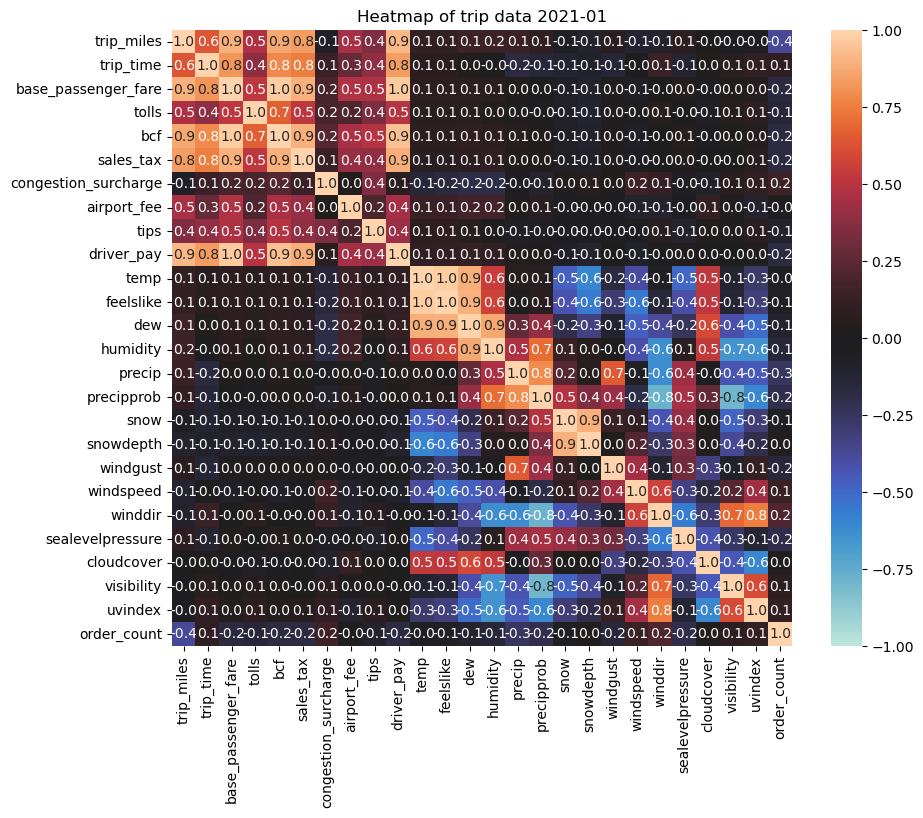

In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(trip_dataset.corr(),cmap="icefire", norm=plt.Normalize(-1,1), annot=True, fmt='.1f')
plt.title("Heatmap of trip data 2021-01")
plt.show()

Here we apply a simple correlation analysis on features and the target label `order_count`, we hardly see any strong linear correlation among the target label and any features (except features `trip_miles` and `precip` show a weak correlation there). Therefore, we first build a Lasso Regression Model to figure out what is most relevant features to the number of orders in each NYC area per day.

In [36]:
trip_dataset['PULocationID'] = trip_dataset.index.get_level_values('PULocationID')
trip_dataset['pickup_datetime'] = trip_dataset.index.get_level_values('pickup_datetime')
# trip_dataset['preciptype'] = trip_dataset['preciptype'].astype(int)
trip_dataset.reset_index(drop=True,inplace=True)
trip_dataset.head()

trip_miles   trip_time  base_passenger_fare     tolls       bcf  sales_tax  \
0    4.523962  765.178060            14.797393  0.380684  0.452909   1.315358   
1    5.149159  923.071681            17.691204  0.488504  0.563168   1.563982   
2    7.935000  909.530303            22.803939  1.407273  0.733636   1.455909   
3    5.582340  821.925532            16.262766  1.710213  0.540213   1.510957   
4    4.997414  822.996703            16.529213  0.872398  0.525389   1.487282   

   congestion_surcharge  airport_fee      tips  driver_pay  ...   windgust  \
0              0.043720     0.000000  0.161876   12.507790  ...  45.800079   
1              2.703761     0.000000  0.294283   14.663354  ...  46.265265   
2              0.041667     0.000000  0.608182   18.855455  ...  45.967424   
3              0.117021     0.000000  0.267660   14.320000  ...  47.051596   
4              0.354922     0.003533  0.451611   13.293943  ...  45.629204   

   windspeed     winddir  sealevelpressure  cloudcover  visibility   uvindex  \
0  23.777424  209.921145       1016.691733   52.956757   14.871224  3.745628   
1  24.598850  220.611062       1016.225929   50.404690   15.044425  3.900885   
2  22.968182  194.709091       1018.296970   52.021212   14.751515  3.757576   
3  23.603191  196.574468       1017.570213   53.670213   14.669149  3.510638   
4  24.037824  216.877956       1016.271503   50.915120   15.009609  3.835610   

   order_count  PULocationID  pickup_datetime  
0          629             3                0  
1         1130             4                0  
2           66             5                0  
3           94             6                0  
4         2123             7                0  

[5 rows x 28 columns]

Now split the trip data of Janurary and feed it to ML models in the next section.

In [37]:
# Target label
y = np.asarray(trip_dataset['order_count'])

# Train features
X = np.asarray(trip_dataset.drop(['order_count'],axis=1)) # (6184, 28) -> 10 features

# shuffle and randomize (not compulsory)
# rng = np.random.default_rng(seed=42) # same seed to keep indices match
# rng.shuffle(X)
# rng = np.random.default_rng(seed=42) # same seed to keep indices match
# rng.shuffle(y)

# normalization
# X_norm = preprocessing.StandardScaler().fit_transform(X) # normalization
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (4947, 27) (4947,)
Test set: (1237, 27) (1237,)


## Modeling

### Lasso Regression Model

In [38]:
# grid search parameters
parameters ={'alpha':np.arange(0,1,0.05)}
lasso_model = Lasso()

start = perf_counter()
lasso_cv = GridSearchCV(lasso_model,parameters,cv=10,scoring='r2',verbose=3) # cross-validation = 10
lasso_cv.fit(X_train,y_train)
end = perf_counter()
print("tunning time: ",end - start)

print("tuned hpyerparameters :(best parameters) ",lasso_cv.best_params_)
print("accuracy :",lasso_cv.best_score_)
print("accuracy on the test data: ",lasso_cv.score(X_test,y_test))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10] END ........................alpha=0.0;, score=0.276 total time=   0.1s
[CV 2/10] END ........................alpha=0.0;, score=0.350 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.305e+09, tolerance: 7.708e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of 

[CV 3/10] END ........................alpha=0.0;, score=0.395 total time=   0.1s
[CV 4/10] END ........................alpha=0.0;, score=0.452 total time=   0.1s
[CV 5/10] END ........................alpha=0.0;, score=0.378 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.323e+09, tolerance: 7.698e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent wit

[CV 6/10] END ........................alpha=0.0;, score=0.388 total time=   0.1s
[CV 7/10] END ........................alpha=0.0;, score=0.376 total time=   0.1s
[CV 8/10] END ........................alpha=0.0;, score=0.350 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.336e+09, tolerance: 7.734e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent wit

[CV 9/10] END ........................alpha=0.0;, score=0.390 total time=   0.1s
[CV 10/10] END .......................alpha=0.0;, score=0.406 total time=   0.1s
[CV 1/10] END .......................alpha=0.05;, score=0.273 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.730e+08, tolerance: 7.557e+05
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.131e+09, tolerance: 7.590e+05
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

[CV 2/10] END .......................alpha=0.05;, score=0.350 total time=   0.2s
[CV 3/10] END .......................alpha=0.05;, score=0.396 total time=   0.1s
[CV 4/10] END .......................alpha=0.05;, score=0.453 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.219e+07, tolerance: 7.541e+05
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+09, tolerance: 7.698e+05
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

[CV 5/10] END .......................alpha=0.05;, score=0.379 total time=   0.1s
[CV 6/10] END .......................alpha=0.05;, score=0.388 total time=   0.1s
[CV 7/10] END .......................alpha=0.05;, score=0.376 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.015e+09, tolerance: 7.492e+05
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.113e+09, tolerance: 7.734e+05
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

[CV 8/10] END .......................alpha=0.05;, score=0.350 total time=   0.1s
[CV 9/10] END .......................alpha=0.05;, score=0.391 total time=   0.1s
[CV 10/10] END ......................alpha=0.05;, score=0.405 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.868e+08, tolerance: 7.708e+05
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.597e+07, tolerance: 7.557e+05
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

[CV 1/10] END ........................alpha=0.1;, score=0.271 total time=   0.1s
[CV 2/10] END ........................alpha=0.1;, score=0.350 total time=   0.1s
[CV 3/10] END ........................alpha=0.1;, score=0.396 total time=   0.1s
[CV 4/10] END ........................alpha=0.1;, score=0.454 total time=   0.1s
[CV 5/10] END ........................alpha=0.1;, score=0.379 total time=   0.1s
[CV 6/10] END ........................alpha=0.1;, score=0.388 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.894e+08, tolerance: 7.698e+05
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.046e+07, tolerance: 7.616e+05
  model = cd_fast.enet_coordinate_descent(


[CV 7/10] END ........................alpha=0.1;, score=0.376 total time=   0.2s
[CV 8/10] END ........................alpha=0.1;, score=0.350 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.516e+08, tolerance: 7.492e+05
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.985e+08, tolerance: 7.734e+05
  model = cd_fast.enet_coordinate_descent(


[CV 9/10] END ........................alpha=0.1;, score=0.392 total time=   0.1s
[CV 10/10] END .......................alpha=0.1;, score=0.404 total time=   0.1s
[CV 1/10] END ........alpha=0.15000000000000002;, score=0.268 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.383e+07, tolerance: 7.625e+05
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.161e+08, tolerance: 7.708e+05
  model = cd_fast.enet_coordinate_descent(


[CV 2/10] END ........alpha=0.15000000000000002;, score=0.350 total time=   0.1s
[CV 3/10] END ........alpha=0.15000000000000002;, score=0.396 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.855e+07, tolerance: 7.590e+05
  model = cd_fast.enet_coordinate_descent(


[CV 4/10] END ........alpha=0.15000000000000002;, score=0.455 total time=   0.1s
[CV 5/10] END ........alpha=0.15000000000000002;, score=0.379 total time=   0.1s
[CV 6/10] END ........alpha=0.15000000000000002;, score=0.388 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.707e+07, tolerance: 7.698e+05
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.428e+07, tolerance: 7.492e+05
  model = cd_fast.enet_coordinate_descent(


[CV 7/10] END ........alpha=0.15000000000000002;, score=0.377 total time=   0.1s
[CV 8/10] END ........alpha=0.15000000000000002;, score=0.350 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.807e+07, tolerance: 7.734e+05
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.640e+05, tolerance: 7.625e+05
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

[CV 9/10] END ........alpha=0.15000000000000002;, score=0.392 total time=   0.1s
[CV 10/10] END .......alpha=0.15000000000000002;, score=0.404 total time=   0.1s
[CV 1/10] END ........................alpha=0.2;, score=0.266 total time=   0.1s
[CV 2/10] END ........................alpha=0.2;, score=0.350 total time=   0.1s
[CV 3/10] END ........................alpha=0.2;, score=0.397 total time=   0.1s
[CV 4/10] END ........................alpha=0.2;, score=0.456 total time=   0.1s
[CV 5/10] END ........................alpha=0.2;, score=0.380 total time=   0.2s
[CV 6/10] END ........................alpha=0.2;, score=0.389 total time=   0.1s
[CV 7/10] END ........................alpha=0.2;, score=0.377 total time=   0.1s
[CV 8/10] END ........................alpha=0.2;, score=0.350 total time=   0.1s
[CV 9/10] END ........................alpha=0.2;, score=0.393 total time=   0.1s
[CV 10/10] END .......................alpha=0.2;, score=0.403 total time=   0.1s
[CV 1/10] END ..............

[CV 3/10] END .........alpha=0.7000000000000001;, score=0.396 total time=   0.0s
[CV 4/10] END .........alpha=0.7000000000000001;, score=0.461 total time=   0.0s
[CV 5/10] END .........alpha=0.7000000000000001;, score=0.383 total time=   0.0s
[CV 6/10] END .........alpha=0.7000000000000001;, score=0.388 total time=   0.0s
[CV 7/10] END .........alpha=0.7000000000000001;, score=0.379 total time=   0.0s
[CV 8/10] END .........alpha=0.7000000000000001;, score=0.350 total time=   0.0s
[CV 9/10] END .........alpha=0.7000000000000001;, score=0.396 total time=   0.0s
[CV 10/10] END ........alpha=0.7000000000000001;, score=0.400 total time=   0.0s
[CV 1/10] END .......................alpha=0.75;, score=0.270 total time=   0.0s
[CV 2/10] END .......................alpha=0.75;, score=0.350 total time=   0.0s
[CV 3/10] END .......................alpha=0.75;, score=0.396 total time=   0.0s
[CV 4/10] END .......................alpha=0.75;, score=0.461 total time=   0.0s
[CV 5/10] END ..............

In [39]:
# best alpha should be close to 0.1
best_lasso_model = Lasso(alpha=0.1)
best_lasso_model.fit(X,y)
print(best_lasso_model.coef_)
print(best_lasso_model.intercept_)

[-7.55774818e+02  2.91124317e+00 -4.21712168e+01 -5.91445116e+01
  9.87969589e+02 -1.29753483e+01  7.86690828e+01  9.14131997e+02
 -4.32264728e+02  1.74389485e+02 -6.13585618e+02  4.43081519e+02
 -3.62579145e+01 -2.06543493e+00  5.20618466e+01 -8.40327643e+00
 -3.52991021e+02  9.70330290e+02  1.04680248e+01 -1.93658389e+00
  2.62112903e+00 -1.58208296e+01  2.18823950e+01 -1.89097164e+02
  4.14717866e+02  2.15159469e-02  2.69125117e+01]
16837.338665981344


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.454e+06, tolerance: 1.080e+06
  model = cd_fast.enet_coordinate_descent(


In [40]:
feature_ratios = best_lasso_model.coef_
print(feature_ratios)
coef_threshold = sum(abs(feature_ratios))/len(feature_ratios)

[-7.55774818e+02  2.91124317e+00 -4.21712168e+01 -5.91445116e+01
  9.87969589e+02 -1.29753483e+01  7.86690828e+01  9.14131997e+02
 -4.32264728e+02  1.74389485e+02 -6.13585618e+02  4.43081519e+02
 -3.62579145e+01 -2.06543493e+00  5.20618466e+01 -8.40327643e+00
 -3.52991021e+02  9.70330290e+02  1.04680248e+01 -1.93658389e+00
  2.62112903e+00 -1.58208296e+01  2.18823950e+01 -1.89097164e+02
  4.14717866e+02  2.15159469e-02  2.69125117e+01]


In [41]:
lst = trip_dataset.columns.to_list()
lst.remove('order_count')
lst

['trip_miles',
 'trip_time',
 'base_passenger_fare',
 'tolls',
 'bcf',
 'sales_tax',
 'congestion_surcharge',
 'airport_fee',
 'tips',
 'driver_pay',
 'temp',
 'feelslike',
 'dew',
 'humidity',
 'precip',
 'precipprob',
 'snow',
 'snowdepth',
 'windgust',
 'windspeed',
 'winddir',
 'sealevelpressure',
 'cloudcover',
 'visibility',
 'uvindex',
 'PULocationID',
 'pickup_datetime']

In [42]:
feature_ratios_list = [* zip(feature_ratios,lst)]
drop_cols = []
for item in feature_ratios_list:
#     if item[0] < coef_threshold and item[1]!='PULocationID':
    if item[0] < 0:
        print(item)
        drop_cols.append(item[1])

(-755.7748179813775, 'trip_miles')
(-42.17121679757144, 'base_passenger_fare')
(-59.14451157600219, 'tolls')
(-12.975348278827438, 'sales_tax')
(-432.2647275109724, 'tips')
(-613.5856175500838, 'temp')
(-36.25791445685841, 'dew')
(-2.0654349304340047, 'humidity')
(-8.40327643138235, 'precipprob')
(-352.9910213524407, 'snow')
(-1.936583890279669, 'windspeed')
(-15.820829589452455, 'sealevelpressure')
(-189.09716401304266, 'visibility')


In [43]:
drop_cols.append('order_count')
drop_cols

['trip_miles',
 'base_passenger_fare',
 'tolls',
 'sales_tax',
 'tips',
 'temp',
 'dew',
 'humidity',
 'precipprob',
 'snow',
 'windspeed',
 'sealevelpressure',
 'visibility',
 'order_count']

In [44]:
# Target label
y = np.asarray(trip_dataset['order_count'])

# Train features
X = np.asarray(trip_dataset.drop(drop_cols,axis=1)) # (6184, 28) -> 28 features for the first try

# shuffle and randomize (not compulsory)
# rng = np.random.default_rng(seed=42) # same seed to keep indices match
# rng.shuffle(X)
# rng = np.random.default_rng(seed=42) # same seed to keep indices match
# rng.shuffle(y)

# normalization
# X_norm = preprocessing.StandardScaler().fit_transform(X) # normalization
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (4947, 14) (4947,)
Test set: (1237, 14) (1237,)


In [45]:
# grid search parameters
parameters ={'alpha':np.arange(0,1,0.05)}
lasso_model = Lasso()

start = perf_counter()
lasso_cv = GridSearchCV(lasso_model,parameters,cv=10,scoring='r2',verbose=3) # cross-validation = 10
lasso_cv.fit(X_train,y_train)
end = perf_counter()
print("tunning time: ",end - start)

print("tuned hpyerparameters :(best parameters) ",lasso_cv.best_params_)
print("accuracy :",lasso_cv.best_score_)
print("accuracy on the test data: ",lasso_cv.score(X_test,y_test))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.580e+09, tolerance: 7.708e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of 

[CV 1/10] END ........................alpha=0.0;, score=0.222 total time=   0.1s
[CV 2/10] END ........................alpha=0.0;, score=0.302 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.553e+09, tolerance: 7.557e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent wit

[CV 3/10] END ........................alpha=0.0;, score=0.309 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.566e+09, tolerance: 7.590e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent wit

[CV 4/10] END ........................alpha=0.0;, score=0.390 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.560e+09, tolerance: 7.541e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent wit

[CV 5/10] END ........................alpha=0.0;, score=0.331 total time=   0.1s
[CV 6/10] END ........................alpha=0.0;, score=0.320 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.609e+09, tolerance: 7.698e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent wit

[CV 7/10] END ........................alpha=0.0;, score=0.321 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.527e+09, tolerance: 7.492e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent wit

[CV 8/10] END ........................alpha=0.0;, score=0.298 total time=   0.1s
[CV 9/10] END ........................alpha=0.0;, score=0.323 total time=   0.1s


/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.622e+09, tolerance: 7.734e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/shuheng-mo/opt/anaconda3/envs/uber/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent wit

[CV 10/10] END .......................alpha=0.0;, score=0.318 total time=   0.1s
[CV 1/10] END .......................alpha=0.05;, score=0.222 total time=   0.0s
[CV 2/10] END .......................alpha=0.05;, score=0.302 total time=   0.0s
[CV 3/10] END .......................alpha=0.05;, score=0.309 total time=   0.0s
[CV 4/10] END .......................alpha=0.05;, score=0.389 total time=   0.0s
[CV 5/10] END .......................alpha=0.05;, score=0.331 total time=   0.0s
[CV 6/10] END .......................alpha=0.05;, score=0.321 total time=   0.0s
[CV 7/10] END .......................alpha=0.05;, score=0.321 total time=   0.0s
[CV 8/10] END .......................alpha=0.05;, score=0.298 total time=   0.0s
[CV 9/10] END .......................alpha=0.05;, score=0.324 total time=   0.0s
[CV 10/10] END ......................alpha=0.05;, score=0.318 total time=   0.0s
[CV 1/10] END ........................alpha=0.1;, score=0.223 total time=   0.0s
[CV 2/10] END ..............

[CV 3/10] END .........alpha=0.6000000000000001;, score=0.307 total time=   0.0s
[CV 4/10] END .........alpha=0.6000000000000001;, score=0.388 total time=   0.0s
[CV 5/10] END .........alpha=0.6000000000000001;, score=0.330 total time=   0.0s
[CV 6/10] END .........alpha=0.6000000000000001;, score=0.324 total time=   0.0s
[CV 7/10] END .........alpha=0.6000000000000001;, score=0.323 total time=   0.0s
[CV 8/10] END .........alpha=0.6000000000000001;, score=0.297 total time=   0.0s
[CV 9/10] END .........alpha=0.6000000000000001;, score=0.326 total time=   0.0s
[CV 10/10] END ........alpha=0.6000000000000001;, score=0.318 total time=   0.0s
[CV 1/10] END .......................alpha=0.65;, score=0.229 total time=   0.0s
[CV 2/10] END .......................alpha=0.65;, score=0.301 total time=   0.0s
[CV 3/10] END .......................alpha=0.65;, score=0.307 total time=   0.0s
[CV 4/10] END .......................alpha=0.65;, score=0.388 total time=   0.0s
[CV 5/10] END ..............

In [47]:
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

## Evaluation

## Deployment

### Build UI dashboard using ?

## Feedback

## References

## Acknowlegdement